# Play by the Rules: Internal Representations in a Game-Playing GPT

### Rajen Parekh and Dr. Yair Shenfeld

## 1. Environment Setup Instructions (macOS / Linux)

Follow the instructions below to create a virtual environment, install required packages, and register the notebook kernel.

Open a terminal and run the following commands:

```bash
cd /path to the mnk_transformer folder
chmod +x setup.sh
./setup.sh
```

This will set up a virtual enviroment to run the notebook in.


After the script finishes...
1. Reopen this notebook.
2. In the top-right corner, click the kernel selector (symbol shown below).
3. Choose the kernel named: `Python (TicTacToe)`

<img src="inserted_images/kernel_button.png" width=30>  ⬅️ Kernel Selector

Then, run the cell below, and you’re ready to run and read through the notebook:

In [1]:
from play_against_gpt import play_game
from functions_for_thesis_display import display_random_training_run
from setup import load_from_checkpoint
model = load_from_checkpoint()

## 2. Introduction

### Introduction to GPTs

In recent years, ChatGPT and other similar language models have become widespread. Their main goal is to generate coherent and relevant sentences, and they've gotten pretty good at it. But how does these models actually learn and work? There aren’t strict, universal rules of the English language that can be easily programmed and given to the models. Instead, very abstractly, language models learn by seeing many examples of English text and use these examples to predict the most likely next word in a sequence.

So, how can we get a better sense of how language models learn the task of next word prediction? One approach is to look at a super simple example that does have clear, well-defined rules: tic-tac-toe.

### Motivation

[Phillip Haeusler](https://philliphaeusler.com/posts/tic_tac_toe/) created and wrote a blog post about Tic Tac Transformer, a GPT model trained to play tic-tac-toe that followed Andrej Karpathy's [NanoGPT](https://www.youtube.com/watch?v=kCc8FmEb1nY) architecture. Of course, this is a terrible way to build a good tic-tac-toe bot. The game is so simple we could just explicitly program the best move in each state. But, we're not really intersted in playing tic-tac-toe well. Instead, we can use this model as a tool to learn about language models. In this setup, a move is like a word, and a game is like a sentence. Just as a sentence is built word by word, a game unfolds move by move—and in both cases, each element depends on what came before it. A string of moves must obey the rules of the game to make sense, just like a sentence must follow grammar and meaning to be coherent. Playing a valid game is equivalent to writing a grammatically correct sentence. Playing an optimal game? That’s Shakespeare.<sup>[1]</sup>

Tic-tac-toe is especially useful for this kind of exploration because it is interpretable and simple enough that we can analyze the model’s behavior move by move. Because of this simplicity and interpretabilty, we can use a GPT-style model similar to Tic Tac Transformer trained on tic-tac-toe games to explore three core questions:

- Does the model generate novel games, or simply memorize the training data?
- How does the model learn over time?
- Does it form an internal representation of the game state?

The goal of this thesis is to investigate these questions by running a series of experiments and using interpretability techniques to analyze the model’s behavior. We introduce each experiment it becomes relevant throughout the thesis, using them to isolate different aspects of how the model learns and internalizes the structure of the game. Together, these approaches help reveal how a small GPT learns to play, understand, and make sense of a simple game.

<p><sup>[1]</sup> <small><em>And something we don't focus on in this project. GPTs generally have pretraining and finetuning stages. This project focuses on pretraining, but learning to play optimally is a finetuning task.</em></small></p>

## 3. Model Representation, Architecture, and Training
Before we start discussing our experiments and results, this section provides a relatively abstract description of how the model works. We present information on how data generated and given to the model, the model's architecture, and how the model makes predictions and trains. For a full mathematical description, refer to the appendix.


### Tokenization
We talked about how tic-tac-toe can be seen as a language with moves as its words, but how do we provide this language to our GPT? Large language models like ChatGPT process language by assigning a unique number to each word in the English language in a process called *tokenization*.<sup>[1]</sup> Each number assigned to a word is a *token* . The model then treats the task of generating words as a classification problem: given a sequence of tokens, what is the most likely next token?

<p><sup>[1]</sup> <small><em>Actually, tokenization happens on parts of the English language smaller than words, called subwords. These subwords might be whole words, word stems, or even individual characters, and it also includes numbers, punctuation, and special characters. But, for our purposes, it's simple and accurate enough to think of them as words.</em></small></p>

We mirror this setup in tic-tac-toe by assigning a token to each space on the board, and starting our indexing at zero (because it's computer science). The indexing of the spaces is shown below:

<img src="inserted_images/empty_board_fix.png" width=250>

In addition to the nine board positions, we introduce two special tokens:
- `9` is a start token, placed at the beginning of every game.
- `10` is a padding token, used to pad the game sequence once it's over but the board isn’t yet full. Padding allows us to ensure that every game sequence has the same fixed length for training.

With these eleven tokens, we can represent every game of tic-tac-toe as a list of 10 tokens. Importantly, the tokens don't specify which players made each move. As humans who know the rules of the game, we know that Player A and Player B alternate moves, but the model sees only the sequence of moves, and must implicitly learn this alternation structure during training.

Let's go over an example to clarify. Every game starts with a sequence of `[9]`, and the board looks like the empty board we saw earlier:

<img src="inserted_images/empty_board_fix.png" width=250>

Then, after a few moves have been played, yielding a sequence of `[9, 6, 4, 2, 8, 0]`, we have a board like this:

<img src="inserted_images/half_game.png" width=250>

And finally, when the game ends before the board is full, the rest of the sequence is filled with padding tokens. For example, finishing the game above gives the sequence `[9, 6, 4, 2, 8, 0, 3, 1, 10, 10]` and this board:

<img src="inserted_images/finished_game.png" width=250>

Notice how the sequence length of the completed game is 10, even though the board isn't full? That's because Player A won early, and we used padding tokens to ensure the game sequence was the correct length.

### Generation of example games
To produce examples of games that our GPT could train and test on, we followed the following procedure to build tokenized games:

$$
\begin{array}{ll}
\text{Initialize:} \\
\quad \texttt{game} \leftarrow [\texttt{9}] \quad \text{(the start token)} \\
\quad \texttt{valid\_moves} \leftarrow \{\texttt{0}, \texttt{1}, \texttt{2}, \texttt{3}, \texttt{4}, \texttt{5}, \texttt{6}, \texttt{7}, \texttt{8}\} \\[1ex]

\text{While the game is not over:} \\
\quad \texttt{move} \leftarrow \text{random choice from } \texttt{valid\_moves} \\
\quad \texttt{game.append(move)} \\
\quad \texttt{valid\_moves.remove(move)} \\
\quad \text{Check if there is a winner or the board is full and break loop if so} \\[1ex]

\text{Pad the game to length 10:} \\
\quad \text{While } \texttt{len(game)} < \texttt{10}: \\
\quad\quad \texttt{game.append(10)} \quad \text{(the padding token)}
\end{array}
$$

This resulted in games between players who play without strategy but always play a valid move. This behavior of randomly selecting a valid move is what we want our GPT to learn.


### Model Architecture
Our model is based on Karpathy’s NanoGPT, whose architecture is as follows:

- An embedding layer, which includes token embeddings (a unique vector learned for each token in the vocabulary) and positional embeddings (a unique vector learned for each position in the input sequence). These two vectors are summed at each position to embed the input sequence into a higher-dimensional space.

- A stack of Transformer blocks, each composed of:
  - A LayerNorm, which normalizes the input to stabilize training and improve optimization.
  - A causal self-attention mechanism, which allows each token to attend to earlier tokens in the sequence. This helps the model learn and capture interactions between different elements in the sequence.
  - A multi-layer perceptron (MLP), which is a feedforward neural network that introduces additional nonlinearity to the outputs of the self-attention layer.
  - A residual connection after both the attention and MLP sublayers that adds the input to each sublayer back to its output. This helps preserve information across layers and makes learning easier by allowing the model to make incremental updates rather than relearning everything from scratch.

- A final LayerNorm, followed by a linear layer that maps the final hidden states to a probability distribution over our tokens for next-token prediction.

For a more precise and technical idea of how the model works, check out the GPT Math section of the appendix.

When initializing a GPT, the following parameters can be adjusted:
- `n_embd`, the embedding dimension of the embedding layer
- `n_head`, the number of attention heads in the self-attention mechanism. This must be a factor of `n_embd`
- `n_layer`, the number of transformer blocks in the model

We found that the architecture that Haeusler presented (12-dimensional embeddings, 1 attention head, and 1 transformer layer) was the simplest architecture that was able to learn how to play. This architecture is what is used throughout this project unless stated otherwise.

### Training the Model
How do we train the model? Our GPT is initialized with randomly-initialized weights, but the goal of training is to update these weights so that the model's outputs are as accurate as possible, given the input sequence.

We’ve generated a dataset of full games, each represented as a sequence of 10 tokens. However, we want the model to learn to make predictions after any number of moves, not just at the end of the game. So we split each game into many training examples.

For example, say we have the full game `[9, 6, 4, 2, 8, 0, 3, 1, 10, 10]` in our training dataset. We can generate multiple prediction tasks from this:

- From `[9]`, predict `6`
- From `[9, 6, 4]`, predict `2`
- From `[9, 6, 4, 2, 8, 0, 3, 1]`, predict `10`

The ground truth is always the next token in the sequence. The model is trained by passing in these input sequences, where it predicts probabilities<sup>[1]</sup> for the next token given the input sequence. We compute how accurate its output predictions are and then update the weights to improve performance. We quantify how accurate the model's predictions are by using a loss function called cross-entropy loss, which is calculated as follows:

Let $V = 11$ be the size of our vocabulary.  
Let $p = (p_1, p_2, \dots, p_{11})$ be the model’s predicted probability distribution over the 11 tokens.  
Let $y \in \{1, 2, \dots, 11\}$ be the index of the correct (target) token.

Then the cross-entropy loss is:

$$
\mathcal{L} = -\log(p_y)
$$

This loss is small when the model assigns high probability to the correct token, and large when it assigns low probability to the correct token. 

We typically the average of the loss function over a batch of examples and use this overall loss to change the model.Then, we use backpropagation<sup>[2]</sup> to computing the gradient of the loss with respect to each parameter, and use an optimizer to adjust the weights in a direction that reduces the loss. This model uses the AdamW optimizer, which is a slight modification of gradient descent that typically leads to faster and more stable convergence. Unless stated otherwise, we trained the model for 100,000 iterations, where an iteration is defined one update of the model's weights. Finally, once training is done, we evaluate the model for a final time on an unseen validation dataset.

Here’s some pseudocode showing how the training loop works:
$$
\begin{array}{ll}
\text{Initialize:} \\
\quad \texttt{model} \leftarrow \text{randomly initialized GPT} \\
\quad \texttt{optimizer} \leftarrow \text{AdamW optimizer} \\
\quad \texttt{iter} \leftarrow 0 \\[1ex]

\text{Repeat for 100{,}000 iterations:} \\
\quad \texttt{X, Y} \leftarrow \text{sample a batch of training examples} \\
\quad \texttt{logits} \leftarrow \texttt{model.forward(X)} \\
\quad \texttt{loss} \leftarrow \text{cross-entropy between logits and Y} \\
\quad \texttt{compute gradients of loss} \\
\quad \texttt{update model weights using optimizer} \\
\quad \texttt{iter} \leftarrow \texttt{iter} + 1 \\[1ex]

\text{After training:} \\
\quad \texttt{evaluate model on validation set}
\end{array}
$$

<p><sup>[1]</sup> <small><em>Actually, the model outputs logits, which can then be converted to probabilities. I find it easier to think about probabilities than logits, so we'll pretened these are probabilities. The conversion from logits to probabilities is very simple. </em></small></p>

<p><sup>[2]</sup> <small><em>For a more detailed description on how this is done, check the appendix (possibly if I have time).</em></small></p>

## 4. Answering our Research Questions

### Model Success
First, let's confirm that the model works. This wouldn't be much of a thesis if it didn't, but test it out below. Keep in mind, the model's goal is to play a legal move, not to play *well*, so you should be able to win pretty easily, but note how it plays by the rules. Click play on the cell below and interact with the buttons to play against the model. *How* does this model learn? Well, that's what we'll discuss in the rest of this document.

In [2]:
play_game(model)

### Model Originality

We've seen above that the trained model can successfully play a game of tic-tac-toe. But how does it do that? Might it just be memorizing the games we showed it as it trained, and repeating them back exactly? This would be bad, especially when we think about what it would mean for language models: what if ChatGPT could only regurgitate exact writing that it had seen before? These models are only useful if they can generate novel games (or text), so we test this capability.

To test the model's creativity, we train the model on 100,000 synthetically generated games of tic-tac-toe.<sup>[1]</sup> These games are created by randomly choosing a move for players until one player wins or the board is filled. After training, we have the model generate 1,000 games and measure how many of them appeared in the training set.

$$
\text{Originality Score} = 1 - \frac{\text{\# of generated games present in training dataset}}{\text{total \# of games generated}}
$$

There are 255,168 possible games of Tic-Tac-Toe, so we would expect originality scores around<sup>[2]</sup>

$$
\frac{255,\!168 - 100,\!000}{255,\!168} \approx 60.8\%
$$

Across 100 training trials (61 of which learned to play successfully before 100k iterations, which we'll call the models that "converged" later on), the mean originality score was 58.1%. So, the model is able to generate unseen game sequences at approximately the rate we'd expect.<sup>[3]</sup> It is not memorizing, but instead seems to be learning the rules of the game and generating games it has never seen before. We'll explore how it does that in the following section.

<p><sup>[1]</sup> <small><em>The model architecture is detailed in the appendix. These models were trained with 1 transformer layer, 1 attention head, and a 12-dimensional embedding.</em></small></p>

<p><sup>[2]</sup> <small><em>We would actually expect an originality score slightly higher than 60.8%, because the synthetic games are randomly generated, and can include overlapping games. A dataset with 100,000 elements is highly unlikely to have 100,000 distinct elements, but this is an expected floor for our originality score.</em></small></p>

<p><sup>[3]</sup> <small><em>This value is slightly smaller than the rate we'd expect. I think this is happening because some of the 255,168 games are more likely to occur when creating the synthetic dataset. For example, to match a short game when Player A wins quickly, only five moves need to match, but to match a long game, nine moves need to match. This means the short games are more likely to be generated synthetically (and be in our training data), and are more likely to be generated by any model that selects between moves randomly. This should drive originality scores down.</em></small></p>


### Learning the Rules of the Game
What are the rules of tic-tac-toe? Without thinking about any strategy, we can define two things a player needs to do in order to play by the rules:

1. Pick a space that neither player has played in before to place their token. A space can't be occupied by multiple tokens, and if a player tries to play on top of another token, a mistake has been made.

2. Three tokens in a row wins the game. If the game is over and a player tries to play, or the game is not over and a player states that it is, a mistake has been made.

**Keep these rules in mind!** They'll be very important for the rest of this document.

Let's take a closer look at the 62 training trials that learned to play successfully to see how these models might be learning the two rules stated above. Plotted below is the validation loss by iteration for each of the trials.<sup>[1]</sup> The graph is a little messy since there are so many trials shown, but take a look and see if you notice a trend:

<p><sup>[1]</sup> <small><em>We use categorical cross-entropy loss. The calculation of this loss is defined in the model architecture and training section.</em></small></p>

<img src="inserted_images/converging_runs.png" width=1000>

Notice how many trials stall with a validation loss between 1.36 and 1.37? In fact, >70% of the runs that converge exhibit this stalling behavior for at least 5,000 iterations. Let's take a closer look at them and see what's going on...

We'll define two new statistics to measure how well a model understands the rules:
1. Invalid Move Rate: This measures how often the model generates a move that has been previously played in the game sequence. It is computed over all generated games (rather than all generated moves), so if a game has any invalid move, it counted towards the invalid rate. It is calculated as follows:

$$
\text{Invalid Move Rate} = \frac{\text{\# of generated games with an occupied space generated}}{\text{Total \# of generated games}}
$$

2. Correct Ending Rate: This measures how often the model predicts that the padding token will be the next token when given a game with a winner. In the training data, whenever a game ends before 9 moves (meaning a player has won before the board is full), the game sequence contains padding tokens to preserve the full sequence length. Once a model learns Rule 2, it should always predict the padding token when given a completed game to mirror this pattern in the training data.<sup>[1]</sup> It is calculated as follows:

$$
\text{Correct Ending Rate} = \frac{\text{\# of correct padding predictions after a win}}{\text{\# of generated games resulting in either player winning}}
$$

Run the cell below to randomly select one of the trials that exhibited this stalling behavior. Notice the pattern between the validation loss (rescaled to fit on the same axes), the invalid move rate, and the correct ending rate.

<p><sup>[1]</sup> <small><em>I actually made a small mistake while running tests, and only tested identifying the padding token on non-full boards (games that ended in 8 moves or less). I didn't have time to fully re-run the experiments, but from a few trials to confirm that performance was the same, I saw no difference in results. </em></small></p>

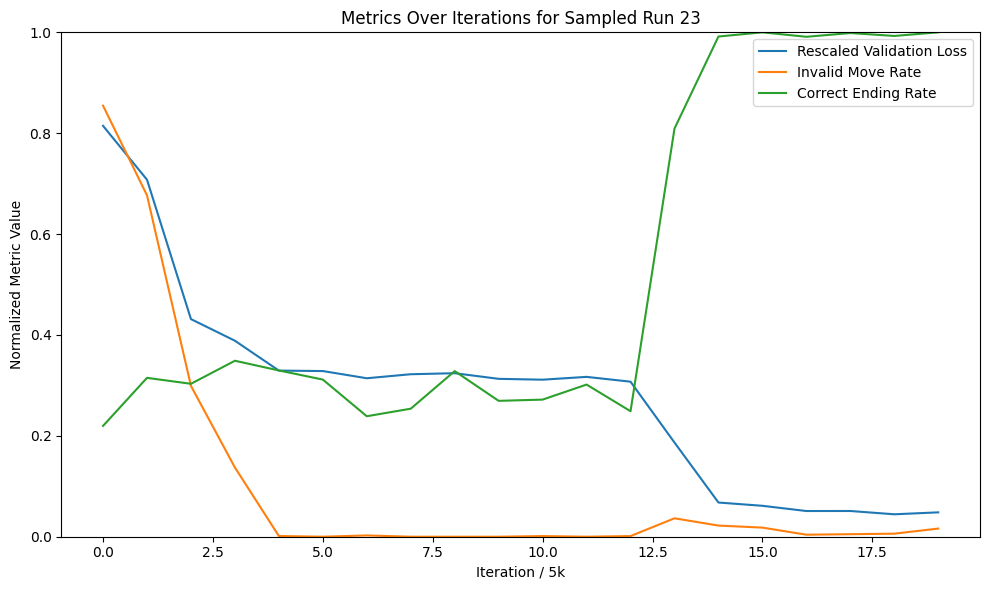

In [3]:
display_random_training_run()

The first thing to note is that, in all of these trials, the correct ending rate approaches 1 and the invalid move rate approaches 0 by the end of training. This means that by the end of training, the model successfully learns the rules of tic-tac-toe! It can avoid playing in occupied spaces and identifies when the game has been won.

Next, observe that the validation loss drops in two stages. During the first one, the invalid move rate drops nearly to 0, but the correct ending rate stagnates and/or fluctuates randomly, showing no improvement. Then, during the second drop, the invalid move rate increases slightly while the correct ending rate drastically increases. As training finishes, the correct ending rate gets even higher, and the invalid move rate slowly decreases back towards 0. This trend holds for all of the trials that stall with a loss between 1.36 and 1.37 for at least 5,000 iterations. Keep hitting play on the cell above to randomly select more trials and confirm this trend.

Clearly, the model seems to be learning the two rules of tic-tac-toe separately, first learning to play in unoccupied spaces and next learning to identify winners, but what is going on internally when this happens? *How* does this learning occur?

### Internal Game Representation

#### Background Work
A [research team from Harvard, MIT, and Northeastern](https://arxiv.org/abs/2210.13382) created a model called OthelloGPT, which was a GPT trained to generate games of Othello, another simple board game. Like our tic-tac-toe GPT, it was able to generate valid moves with very few errors. This team's central question was whether OthelloGPT had learned an internal representation of the game state without knowledge of the rules of the game.

To study this, they introduced *probes*:classifiers trained to predict the state of each space on the board (empty, Player A, or Player B) from the model’s internal activations after being given a sequence of moves. For each layer, they created a dataset by pairing the activations at that layer with the board state implied by the input sequence that produced them. This allowed them to evaluate what information about the board was encoded at different depths of the model.

They compared probes trained on a randomly initialized model with probes trained on a fully trained model. On the untrained model, both linear and nonlinear probes performed poorly, showing that the probes themselves were not powerful enough to extract board state from random transformations of the input sequence. On the trained model, however, a nonlinear probe was able to recover the full board state with up to 98% accuracy. This is notable because it shows that during training, OthelloGPT developed an internal representation of the game state, *even though it was never explicitly told the rules of the game, and was only asked to predict the next move*. The linear probe, by contrast, still struggled, performing only slightly better on the trained model than on the untrained model. This suggests that the learned representation was  nonlinear and not directly accessible with a simple linear decoder.

However, [Neel Nanda](https://www.neelnanda.io/mechanistic-interpretability/othello) further investigated the internal game representation of OthelloGPT. Instead of training the probe to classify a space as Player A/Player B/Empty, he modified the task to classify a space as "Me"/"You"/Empty from the perspective of the model. Pieces placed by the player about to act are "Me" spaces, and places placed by the current player's opponent are "You" spaces. With this modified task, he found that a linear probe was able to reconstruct the board state. 

Here's what this other approach looks like for tic-tac-toe:
Say we have input sequence `[9, 2, 5, 3, 4, 0]`. Recall from the model architecture section that 9 is the start token, and the remaining tokens indicate where Player A and Player B place their alternating moves. In a Player A/Player B representation, the board unsurprisingly looks as follows:

<img src="inserted_images/p1_p2_board_edit.png" width=250>

But, in a Me/You system, the current player is Player B, so Player B's tokens are counted as Me and Player A's are counted as You:

<img src="inserted_images/me_opp_board.png" width=250>

Now, observe what happens when we add another move to the game, making our input sequence `[9, 2, 5, 3, 4, 0, 7]`. The original moves on the Player A/Player B board are unchanged:

<img src="inserted_images/p1_p2_board_update_edit.png" width=250>

But, the original moves on the Me/You board have flipped, because the current player is now Player:

<img src="inserted_images/me_opp_board_update.png" width=250>

We'll use this modified task later on, so make sure you understand the difference.


#### Our Questions
Based on these two studies of OthelloGPT, we attempt to apply a version of probing to our model. Our main goal is to understand more about two-stage learning the model exhibits, and to do so, we ask three questions:
1. Does our model learn an internal representation of the board state, like OthelloGPT?
2. Is this representation linear or nonlinear?
3. How does the internal representation change when the model is at different stages of the training process? And specifically, what happens before and after the model stalls with a validation loss from 1.36-1.37 range?

#### Different Tasks to Test
To learn more about our model's behavior, we define four tasks to test our probe on. The first two directly mirror Rule 1 and Rule 2 of tic-tac-toe, which we defined above. The next two relate to the identity of the player occupying each space and allow us to directly compare the classification tasks of the original Othello paper and Nanda's update. Together, these tasks let us examine different aspects of the model’s internal understanding of the game. The tasks are defined below:

1. **Space Occupancy**: What spaces are occupied?
2. **Winner Detection**: Has the game been won?
3. **A/B Occupancy**: Which player has played in each space, using Player A's vs Player B's space?
4. **Me/You Occupancy**: Which player has played in each space, using Me vs You space?

#### Different Probe Architectures
We also want to be sure that if there are differences in performance between linear and nonlinear probes, this difference is due to the nonlinearity of the internal representation, not just that nonlinear probes have more parameters and are more powerful. <sup>[1]</sup> In order to test this, we use three probes: a linear probe, a small MLP, and a large MLP. The number of parameters for each model and task are shown in the table below:<sup>[2]</sup>

|              | Space Occupancy | Winner Detection | A/B Occupancy | Me/You Occupancy |
|--------------|--------|--------|--------|--------|
| Linear       |    351    |    26    |   351     |     351   |
| Small MLP    |   507     |     182   |    507    |   507     |
| Large MLP    |   1403     |    978    |   1403     |    1403    |

For most tasks, the small MLP is closer in number of parameters to the linear model than it is to the large MLP. This means that if we see a large performance gap between the linear model and the small MLP, but a small performance gap between the small MLP and the large MLP, we can probably attribute the difference to an inherently nonlinear representation, not a more complex probe. 

<p><sup>[1]</sup> <small><em>The size of the linear vs. nonlinear probes is actually not mentioned in the original Othello paper, so this is an important new addition for us to test. </em></small></p>

<p><sup>[2]</sup> <small><em>Exact probe architecture is detailed in the appendix. </em></small></p>



#### Results Part 1: Internal Representation Existence and Linearity
In order to train the probes on activation-board pairs, we need to train a GPT to generate these pairs. The training run for the GPT used to generate probing data is displayed below. Circled locations are where checkpoints were taken. From left to right, the checkpoints represent key moments in training:

- A **Random** model (Checkpoint 1) with weights initialized before any training
- The model where **Stalling Begins** (Checkpoint 2), when validation loss first hits 1.37 and stalling behavior begins
- The model where **Stalling Ends** (Checkpoint 3), as validation loss reaches 1.36 and stalling behavior ends
- The **Fully Trained** model (Checkpoint 4) after 100,000 iterations

<img src="inserted_images/checkpoint_locs.png" width=500>



To generate data, we begin by loading the trained GPT model at each of the four checkpoints. We use a dataset consisting of full tic-tac-toe games, each encoded as a sequence of tokens as discussed in the Model Representation section. These sequences represent complete games, but we do not feed the entire sequence to the model all at once. Instead, for each game, we create a series of 10 truncated input sequences: the first contains only the start token, the second contains the start token followed by the first move, the third includes the first two moves, and so on, up to the full sequence of 10 tokens. This results in 10 distinct input sequences per game, each representing a partial progression of the game state.

Each of these input sequences is fed through the model, and we extract the corresponding internal activations after three layers of the model:
1. The **Embedding** layer
2. The **Transformer** block
3. The final **LayerNorm** after the transformer. 

These activations become the input features used to train the probing models.

The corresponding ground truth labels are derived directly from the input sequences by decoding the tokenized moves to reconstruct the board state at that point in the game. Depending on the specific probing task, the label is either a classification for each of the 9 spaces on the board (e.g., predicting whether a space is X, O, or empty), or a binary label indicating whether the board has a winner. This procedure is repeated independently for each checkpoint, enabling us to compare how the internal representations evolve over the course of training.

Once the probing data is generated, we are left with a distinct dataset for each combination of checkpoint and layer: one for the embedding layer, one for the first transformer block, and one for the final LayerNorm layer, at each of the four checkpoints. Each of these datasets is split into a training set of 100,000 examples and a validation set of 20,000 examples. We train a separate probe on the training portion of each dataset and evaluate it on the corresponding validation set. For Space Occupancy, A/B Occupancy, and Me/You occupancy, we compute space accuracy, defined as the percentage of individual board spaces the probe correctly classifies. For Winner Detection, we compute board-level accuracy, which measures how often the probe correctly determines whether or not the board contains a winner.

Results of this experiment are shown in tables below. In this section, we'll focus on whether there is an internal representation, whether it is linear, and where within the model this representation is learned. The results compare four probes: a linear, a small MLP, and a large MLP using data from the **Fully Trained** Checkpoint and a large MLP using data from the **Random** Checkpoint. Because this is a randomly initialized model, this large MLP probe serves as a baseline of how well the most powerful probe can do using activations from an untrained model. We can compare the other three probes trained on **Fully Trained** data to this baseline to understand how much the GPT's internal representation improves during training.


#### Task 1: Space Occupancy

| Probe Type           | Embedding | Transformer | LayerNorm |
|----------------------|---------|---------|---------|
| Linear               | 0.774   | 0.936   | 0.943   |
| Small MLP            | 0.788   | 0.953   | 0.973   |
| Large MLP            | 0.788   | 0.977   | 0.988   |
| Large MLP (Baseline)| 0.760   | 0.764   | 0.829   |

**1. Is there an internal representation?**  
*Yes*. By the LayerNorm, all three probes trained on the Fully Trained checkpoint greatly outperform the baseline probe. This suggests the GPT learns an internal representation of space occupancy.

**2. Where is this representation learned?**  
It seems to be mostly learned the transformer layer. This is where we see probe accuracy spike.

**3. Is this representation linear?**  
*Mostly*. The linear probe is able to make predictions that are nearly as accurate as either of the MLP probes. The nonlinear probes do slightly outperform the linear probe, so there might be some nonlinearity in the representation.


#### Task 2: Winner Detection

| Probe Type     | Embedding | Transformer | LayerNorm |
|----------------------|---------|---------|---------|
| Linear               | 0.924   | 0.919   | 0.954   |
| Small MLP            | 0.925   | 0.986   | 0.986   |
| Large MLP            | 0.922   | 0.987   | 0.988   |
| Large MLP (Baseline)| 0.912   | 0.922   | 0.924   |

**1. Is there an internal representation?**  
*Yes*. By the LayerNorm, all three probes trained on the Fully Trained Checkpoint greatly outperform the baseline probe. This suggests the GPT learns an internal representation of whether the game has been won.

**2. Where is this representation learned?**  
The MLP probes learn this representation by the transformer layer. However, the linear probe only achieves accuracy above baseline at Layer 3, the LayerNorm.

**3. Is this representation linear?**  
*Somewhat*. The MLP probes perform similarly to each other, and far outperform the linear probe, but the linear probe does substantially outperform the baselie probe. The fact that the MLP probes learn the internal represenation before Layer 3, while the linear probe does not, suggests that the GPT's LayerNorm removes some, but not all, of the nonlinearity of the representation, allowing the linear probe to perform better.




#### Task 3: A/B Occupancy
| Probe Type        | Embedding | Transformer | LayerNorm |
|----------------------|---------|---------|---------|
| Linear               | 0.609   | 0.729   | 0.732   |
| Small MLP            | 0.620   | 0.783   | 0.778   |
| Large MLP            | 0.665   | 0.796   | 0.798   |
| Large MLP (Baseline)| 0.663   | 0.674   | 0.698   |

**1. Is there an internal representation?**  
*Yes*. By the LayerNorm, both MLP probes trained on the Fully Trained Checkpoint greatly outperform the baseline probe, and the linear probe slightly outperforms baseline. This suggests the GPT learns some internal representation of space occupancy from a Player A-Player B perspective.

**2. Where is this representation learned?**  
All three probes learn this representation by the transformer layer. The LayerNorm does not further increase probe accuracy.

**3. Is this representation linear?**  
*No*. The MLP probes perform similarly to each other, and far outperform the linear probe. The linear probe does perform better than baseline, but not substantially so.


#### Task 4: Me/You Occupancy

| Probe Type          | Embedding | Transformer | LayerNorm |
|----------------------|---------|---------|---------|
| Linear               | 0.642   | 0.768   | 0.833   |
| Small MLP            | 0.668   | 0.877   | 0.871   |
| Large MLP            | 0.670   | 0.900   | 0.901   |
| Large MLP (Baseline)| 0.667   | 0.637   | 0.697   |

**1. Is there an internal representation?**  
*Yes*. By the LayerNorm, all three probes trained on Checkpoint 4 greatly outperform the baseline probe. This suggests the GPT learns an internal representation of space occupancy from a me-you perspective.

**2. Where is this representation learned?**  
The MLP probes learn this representation by the transformer layer. The linear probe achieves accuracy over baseline by the transformer layer, but is substantially more accurate after the LayerNorm.

**3. Is this representation linear?**  
*Somewhat*. The MLP probes perform similarly to each other, and far outperform the linear probe. The linear model does, however, perform substantially better than baseline. The increase in the linear probe's performacne between Layer 2 and Layer 3 suggests that the GPT's LayerNorm removes some nonlinearity from its internal representation, making it more accessible to linear probes.

#### Overall summary
The success of the probes suggests the GPT model develops internal representations for each task, even though it was not explicitly trained to do so. These representations are largely formed in the transformer layer, with the LayerNorm layer sometimes refining them and making them more accessible to linear probes. For all space occupancy tasks, we see a noticeable spike in accuracy for all probe types at the transformer layer, indicating that it encodes information relevant to these internal representations. For winner detection and A/B occupancy, the LayerNorm layer further boosts linear probe performance, suggesting that it helps transform these nonlinear representations that the transformer produces into a more linearly decodable form. 

While linear probes consistently outperform the baseline, they are typically outperformed by both the small and large MLP probes. This pattern, observed across all tasks, suggests that the internal representations are only partially linear.

A/B occupancy and Me/You occupancy mirror the tasks tested by the OthelloGPT team and Nanda, respectively. Consistent with Nanda's work, all probe types perform better on the Me/You task than on the A/B task. This supports the idea that the model interprets and represents the board from the perspective of the *current player*. However, our results diverge from Nanda’s in a key way: while Nanda concluded that A/B occupancy could be fully represented with a linear probe, we find that the nonlinear probes still substantially outperform the linear probe in this setting. This indicates that the GPT's internal representation of the Me/You task is still meaningfully nonlinear. This result aligns more closely with conclusions from the OthelloGPT team, who found that nonlinear probes are needed to access the model’s internal board state representations.


#### Results Part 2: Changes in Internal Representation During Training
Now that we know that the GPT eventually learns an internal represenation of the game state, we'll explore how this representation develops as the model trains. Recall the two rules we defined for tic-tac-toe. In particular, we observed that the GPT first learns to not play in occupied spaces (Rule 1) at the Stalling Begins checkpoint, and later learns to correctly identify the end of games (Rule 2) at the Stalling Ends Checkpoint. Is this because it has different internal representations at these checkpoints? How do the internal represenations change during training?

We test this by comparing the performance of each probe type (Linear, Small MLP, Large MLP) on our four tasks across checkpoints. Space Occupancy explicitly tests model understanding of Rule 1 and Winner Detection explicity tests model understanding of Rule 2. A/B occupancy and Me/You occupancy involve understanding and representing the entire board state, so they require an understanding of Rule 1 and Rule 2.

Presented below are tables for the accuracies of probes trained on each checkpoint from activations taken from the LayerNorm of the GPT, as well as a chart showing how each probe's performance changes across checkpoints. We'll discuss the results below.



#### Linear Probe

| Task     | Random | Stalling Begins | Stalling Ends | Fully Trained |
|----------|--------------|--------------|--------------|--------------|
| Space Occupacny   | 0.660        | 0.948        | 0.932        | 0.943        |
| Winner Detection   | 0.900        | 0.920        | 0.954        | 0.954        |
| A/B Occupancy   | 0.569        | 0.745        | 0.734        | 0.732        |
| Me/You Occupancy  | 0.587        | 0.750        | 0.824        | 0.833        |

#### Small MLP Probe

| Task     | Random | Stalling Begins | Stalling Ends | Fully Trained |
|----------|--------------|--------------|--------------|--------------|
| Space Occupacny   | 0.790        | 0.979        | 0.960        | 0.973        |
| Winner Detection    | 0.923        | 0.921        | 0.987        | 0.986        |
| A/B Occupancy    | 0.649        | 0.769        | 0.755        | 0.778        |
| Me/You Occupancy   | 0.661        | 0.772        | 0.855        | 0.871        |

#### Large MLP Probe

| Task     | Random | Stalling Begins | Stalling Ends | Fully Trained |
|----------|--------------|--------------|--------------|--------------|
| Space Occupacny   | 0.829        | 0.991        | 0.970        | 0.988        |
| Winner Detection    | 0.924        | 0.922        | 0.988        | 0.988        |
| A/B Occupancy    | 0.698        | 0.779        | 0.778        | 0.798        |
| Me/You Occupancy   | 0.697        | 0.792        | 0.879        | 0.901        |

#### Results Plotted

<img src="inserted_images/labeled_accuracy_by_checkpoint_key.png" width=1000>



#### Observations

Take a look at the tables and chart above, and focus on the transition between Checkpoint 2 and Checkpoint 3. As we discussed, this is where the GPT's behavior shifts. At Checkpoint 2, the model has learned not to play invalid moves but cannot identify when the game has ended (invalid move rate is low, but correct ending rate is also low), but at Checkpoint 3, it learns to identify when games have ended (the correct ending rate is now high) . This progression aligns with our two defined rules of tic-tac-toe. Task 1 (Rule 1) and Task 2 (Rule 2) help isolate the internal representation of each rule, while Tasks 3 and 4 depend on a composition of both.

By Checkpoint 2, Task 1 performance is already nearly perfect for all probe types, especially for the nonlinear probes. This suggests that an internal representation of occupied spaces is well established by this point in training. In contrast, performance on Task 2 does not improve until Checkpoint 3, where it jumps to nearly perfect performance, especially for the MLP probes. This shift in Task 2 accuracy mirrors the point at which the GPT starts identifying game ends correctly, suggesting that the internal representation of Rule 2 is not present until this later checkpoint.

Tasks 3 and 4 both require an understanding of both Rule 1 and Rule 2, but they show different patterns. Probes trained on Task 3 see a jump from Checkpoint 1 to 2, then plateaus. Task 4, on the other hand, shows consistent improvement across all checkpoints. This suggests that [WHAT DOES THIS SUGGEST?]

Taken together, these results highlight that the GPT's internal representation of game state evolves in distinct phases. First, it learns to represent occupied spaces (Rule 1) by Checkpoint 1, then it incorporates signals for game termination (Rule 2) by Checkpoint 2. Importantly, the probes help us understand not just *that* the model behaves differently, but *why* it performs differently, by revealing when different understandings of the board state become represented internally by the model. The probing tasks allow us to track these representational changes over time, and the difference in probe performance between Checkpoints 2 and 3 offers strong evidence that the changes in model behavior we observed reflect changes in the model’s internal encoding of the game. While the model could in theory behave correctly without any internal representation of the game, the probes show that such a representation does, in fact, emerge and evolve over training.

## 5. Conclusion

### Summary of Findings
In this project, we trained a GPT to generate valid moves and complete games of tic-tac-toe. We were interested in three main questions:

1. Does the model generate novel games, or just memorize games that it was shown?
2. How does this learning occur?
3. Is there an internal representation of the game? Does it change as the model learns?

To answer the first question, we looked at the full games the model generated and observed what proportion of those were included in the training dataset, and what proportion were original. We found that the model generated original games at around the frequency we'd expect of a model without any memorization, so we concluded that the model was not memorizing, but instead was learning to play tic-tac-toe legally.

To address the second question, we tracked how the model learned over time. In more than 70% of successful training runs, the model's loss decreases in two distinct stages. Each of these stages corresponds to one of the two rules of tic-tac-toe:
1. Play a token in an unoccupied space.
2. If one player places three of their tokens in a row, they win.
 
After the first stage, the model learns to avoid illegal moves where it attempts to play in an already-occupied space (Rule 1). After the second stage, the model learns to recognize when the a player has won by occupying three spaces in a row and stops predicting additional moves, instead predicting the padding token used to signify the end of a game (Rule 2). These shifts in behavior suggest that the model somehow internalizes the basic rules of tic-tac-toe, first learning how to play legally, then learning how the game ends.

For our final question, we were interested in understanding more about how the model learns the rules of the game. To do so, we trained linear and nonlinear probes on the GPT's activations to see if the GPT developed an internal representation of the board state, and if this representation changed throughout training. We defined four probing tasks: Space Occupancy and Winner Detection reflected the rules of tic-tac-toe we defined earlier. A/B Occupancy and Me/You Occupancy involved identifying which player occupied each square (with different framing) and tested understanding of the entire board. For each of these tasks, probes trained on activations from a fully trained GPT outperformed probes trained on activations from an untrained GPT, suggesting that the GPT learned an internal representation of the board. Importantly, the model was not tasked with learning this internal representation, only generating the next valid move, but the representation developed anyway. We tracked the success of the probes across layers and found that this representation was primarily learned by the transformer layer. Because nonlinear probes consistently outperformed linear probes, it seems that this representation is somewhat nonlinear. Improvement in nonlinear probes after the final LayerNorm suggests that this layer removes some nonlinearity from the model's internal representations. Finally, we observed that the internal representation evolved as the GPT trained, and the game state information our probes were able to extract matched the model's generation capabilities at the training stage from which the probe was trained.

Tic-tac-toe isn't exactly language generation, but we studied our GPT using techniques that are also applicable to mechanistic interpretability research on LLMs like ChatGPT. We tested for model originality and memorization, tracked different metrics for learning as the model trained, and introduced probes to investigate how the model internalized its understanding of the game. Of course, GPTs trained on natural language are vastly more complex models trying to learn a much more ambiguous task. They don’t have explicit rules like tic-tac-toe, and their internal representations are shaped by more varied objectives and data. Still, we can apply a similar sort of study: by training a model on next-token prediction, we can begin to uncover how the architecture supports generalization, rule learning, and internal representation. This project shows that even tiny GPTs, trained on simple data, can develop surprisingly complex and accurate internal representations. These toy models offer an environment where we can test hypotheses, develop tools, and build intuition that may eventually scale to more complex work.


### Future Work

While I'm satisfied with my findings in this project, there were a number of tasks/questions I wanted to look into, but didn't have the time to accomplish. I've detailed some avenues for future work below:

#### Generalization to *mnk* Games
Tic-tac-toe is a special case of an *mnk* game (with *m* = *n* = *k* = 3), where players alternate turns on an *m* × *n* board and aim to control *k* consecutive spaces. A natural extension of this project is to explore how the GPT learns to play these more complicated games. I was planning to go in this direction for a while before I noticed the multi-stage learning and decided to investigate that, so my codebase is set up to work with all *mnk* games. Because of that work, it shoudn't be too difficult to extend this project to more general *mnk* cases.

#### Minimum Embedding Dimensionality
As I tested different GPT architecture, I found that a minimum of 12-dimensional embeddings were necessary for the GPT to learn to play legal games. This mirrors what Haeusler found in his original creation of TicTacTransformer. However, neither Heusler nor I propose *why* 12 dimensions might be necessary. This result is especially surprising because, in theory, 11 dimensions should be sufficient to uniquely represent each token given that our vocabulary is only 11 words (all nine moves on the board, the start token, and the pad token). Further investigation to discover why 12-dimensional embeddings are necessary could help us further understand the model's learning process.

#### Interventions on Internal Representations
In addition to training probes on their model's activations, OthelloGPT team demonstrated that it is possible to causally intervene on a model’s internal representations to manipulate its behavior in predictabke ways. In their experiments, they passed in a game sequence to OthelloGPT, then edited the model's activations so that their probes would predict a different board state from the one that was inputted. Using these new activations, the model was told predict the next move. They found that the model predicted moves that were legal on the new board state inferred from the probe, not the original board state given to the model. This showed that the model’s internal representation of game state was not a byproduct of training, but instead was influential in shaping its output. 

A clear next step for this project is to perform similar interventions on our GPT. By editing the model's activations so that our probes predictd a different board state, we could test whether the model's predictions change in response. For example, if we change the activations such that a previously occupied space appears empty, and the model then chooses to place a move there, it would suggest that the model relying on its internal board representation to decide where to play. This kind of intervention would help us figure out whether the internal representations we saw with probes are actually used by the model to guide its predictions, or if they’re just a side effect of training that happen to be decodable by our probes.

## 6. Appendix
Presented here is the math of how a GPT works, as well as a couple of experiments I ran that didn't fit in exactly with the project I wanted to present.

### 1. GPT Math
#### Model Initialization and Configuration

The model is instantiated with a configuration that specifies the following parameters:

- **`block_size`**: the maximum number of tokens the model can process.  
- **`vocab_size (V)`**: the size of the vocabulary, representing all possible moves plus special tokens.  
- **`n_layer (L)`**: the number of Transformer layers in the model.  
- **`n_head (H)`**: the number of attention heads in each Transformer layer.  
- **`n_embd (N)`**: the dimensionality of the token and position embeddings.  
- **`mlp_mult`**: a scalar multiplier controlling the hidden size of the MLP layers.  

The model is instantiated with a configuration that specifies the following parameters:

We adopt the following indexing convention:  
- Capital letters (`T`, `N`, `V`, etc.) denote tensor dimensions.  
- Lowercase letters of the same name (`t`, `n`, `v`, etc.) are used for indexing over those dimensions in pseudocode and equations.

All weight matrices are initialized randomly from a normal distribution 
$$
\mathcal{N}\left(0, \frac{0.02}{\sqrt{2 \cdot \texttt{n\_layer}}} \right)
$$

#### Token Embeddings

To access token embeddings, the model uses a weight matrix `W_e` with dimensions `(vocab_size, N)`, where each row `W_e[i]` contains the embedding for the *i*-th item in the vocabulary.

Given an input sequence `x` of token indices with shape `(T)`, each token is mapped to its corresponding embedding from `W_e`. This produces a token embedding matrix `tok_emb` with dimensions `(T, N)`, where each element `tok_emb[t, n]` is obtained by mapping token `t` to its embedding vector `W_e[t]`, which has size `N`.

```python
# Algorithm: Token Embedding Calculation
for each token x_t in input sequence x:
    tok_emb_t ← W_e[x_t]  # Retrieve embedding for token x_t


#### Position Embeddings

In addition to token embeddings, positional information is added to indicate each token’s position within the sequence. This is achieved through a position embedding matrix `W_p` with dimensions `(block_size, N)`, where each row `W_p[i]` represents the embedding for position *i*.

For a given sequence of length `T`, we retrieve one position embedding for each token position. This produces a position embedding matrix `pos_emb` of shape `(T, N)`.

```python
# Algorithm: Position Embedding Calculation
for each position t in sequence length T:
    pos_emb_t ← W_p[t]  # Retrieve position embedding for position j

#### Combined Embeddings

The full embedding matrix for the input sequence is created by summing the token and position embeddings:

$$
\texttt{emb}[t, n] = \texttt{tok\_emb}[t, n] + \texttt{pos\_emb}[t, n]
$$

where `emb[t, n]` represents the combined embedding at position `t` and embedding dimension `n`.

```python
# Algorithm: Combined Embedding Calculation
for each token position t in sequence length T:
    for each embedding dimension n in range(N):
        emb[t, n] ← tok_emb[t, n] + pos_emb[t, n]  # Sum token and position embeddings
```

The overall embedding matrix has shape `(T, N)`

#### Layer Normalization

Layer normalization is applied to stabilize training by normalizing across the embedding dimension at each token position. The input to LayerNorm has shape `(T, N)`.

For an input `x` of shape `(T, N)`, we compute the mean and variance across the embedding dimension for each position `t`:

$$
\mu_t = \frac{1}{N} \sum_{n=1}^{N} \texttt{x}[t, n]
$$

$$
\sigma^2_t = \frac{1}{N} \sum_{n=1}^{N} (\texttt{x}[t, n] - \mu_t)^2
$$

We normalize each embedding value:

$$
\hat{\texttt{x}}[t, n] = \frac{\texttt{x}[t, n] - \mu_t}{\sqrt{\sigma^2_t + \epsilon}}
$$

where $\epsilon$ is a small constant to prevent division by zero.

Finally, we apply learnable scale and shift parameters `gamma` and `beta`, each of shape `(N)`:

$$
\texttt{y}[t, n] = \texttt{gamma}[n] \cdot \hat{\texttt{x}}[t, n] + \texttt{beta}[n]
$$

The output `y` has the same shape as the input: `(T, N)`.

```python
# Algorithm: Layer Normalization
for each token position t in sequence length T:
    mu_t ← mean over n of x[t, n]
    var_t ← mean over n of (x[t, n] - mu_t)²
    for each embedding dimension n in range(N):
        x_hat[t, n] ← (x[t, n] - mu_t) / sqrt(var_t + epsilon)
        y[t, n] ← gamma[n] * x_hat[t, n] + beta[n]


#### Causal Self-Attention

The next part of the Transformer block is Causal Self-Attention, which takes an input `x` of shape `(T, N)`.

We apply a linear layer with weight matrix `W_qkv` of shape `(N, 3N)` to compute concatenated query, key, and value vectors. For each element `y[t, n]`, we compute:

$$
y[t, n] = \sum_{m=1}^{N} \texttt{W\_qkv}[n, m] \cdot \texttt{x}[t, m]
$$

This produces a tensor of shape `(T, 3N)`, which we split into three separate tensors: query `q`, key `k`, and value `v`, each of shape `(T, N)`.

We then reshape `q`, `k`, and `v` from shape `(T, N)` to `(T, H, D)`, where `D = N / H`.

This is done by interpreting the last dimension `n` as a combination of two indices:
- `h = floor(n / D)` — the head index
- `d = n % D` — the position within the head

More formally, for each tensor `m` in `{q, k, v}`, we define a new view `m_reshaped` such that:

$$
\texttt{m\_reshaped}[t, h, d] = \texttt{m}[t, h \cdot D + d]
$$

We then transpose to move the head dimension first, resulting in shape `(H, T, D)`:

$$
\texttt{m\_transposed}[h, t, d] = \texttt{m\_reshaped}[t, h, d]
$$

Next, we calculate the attention weights by performing a scaled dot product between `q` and `k`:

$$
\texttt{attn\_weight}[h, t, j] = \sum_{d=1}^{D} q[h, t, d] \cdot k[h, j, d]
$$

We apply an attention mask, a matrix of size `(T, T)`, where all values above the diagonal are set to `−∞` and all values at or below the diagonal are 0. This enforces the causal structure.

We then add the attention bias:

$$
\texttt{attn\_weight}[h, t, j] \leftarrow \texttt{attn\_weight}[h, t, j] + \texttt{attn\_bias}[t, j]
$$

We apply the softmax function to convert the attention weights into probabilities:

$$
\texttt{attn\_weight}[h, t, j] = \frac{\exp(\texttt{attn\_weight}[h, t, j])}{\sum_{j'=1}^{T} \exp(\texttt{attn\_weight}[h, t, j'])}
$$

Then, we compute a weighted sum of the value tensor:

$$
\texttt{output}[h, t, d] = \sum_{j=1}^{T} \texttt{attn\_weight}[h, t, j] \cdot v[h, j, d]
$$

This gives a tensor of shape `(H, T, D)`. We then transpose and reshape it back to shape `(T, N)`.

Next, we apply a linear projection `W_c_proj` of shape `(N, N)` to combine the heads:

$$
\texttt{attn\_out}[t, n] = \sum_{m=1}^{N} \texttt{W\_c\_proj}[n, m] \cdot \texttt{output}[t, m]
$$

Finally, we add a residual connection by summing the attention output with the original input:

$$
\texttt{y}[t, n] = \texttt{x}[t, n] + \texttt{attn\_out}[t, n]
$$

This produces the output of the self-attention layer with shape `(T, N)`.

```python
# Algorithm: Causal Self-Attention
# Input: x of shape (T, N)
qkv = x @ W_qkv                        # (T, 3N)
q, k, v = split(qkv)                  # (T, N) each

# Reshape to (T, H, D) and transpose to (H, T, D)
q, k, v = transpose_heads(q, k, v)

# Compute attention weights
attn_weight[h, t, j] = sum over d of q[h, t, d] * k[h, j, d]
attn_weight += attn_bias
attn_weight = softmax(attn_weight)

# Weighted sum of values
output[h, t, d] = sum over j of attn_weight[h, t, j] * v[h, j, d]

# Merge heads and apply projection
output = merge_heads(output)         # shape (T, N)
attn_out = output @ W_c_proj         # shape (T, N)
y = x + attn_out                     # shape (T, N) with residual


#### Feed-Forward Neural Network (MLP)

The next step is the application of an MLP to the self-attention output. The input `x` to the MLP has shape `(T, N)`.

We first apply LayerNorm to the input:

$$
\texttt{x\_norm}[t, n] = \texttt{LayerNorm}(\texttt{x}[t])
$$

We then apply a linear layer with weight matrix `W_1` of shape `(N, mlp_mult × N)`, producing a tensor `h_1` of shape `(T, mlp_mult × N)`. For each token position `t` and output dimension `k`, we compute:

$$
\texttt{h\_1}[t, k] = \sum_{n=1}^{N} \texttt{x\_norm}[t, n] \cdot \texttt{W\_1}[n, k]
$$

We then apply the GELU activation function **elementwise** to `h_1`. That is:

$$
\texttt{h\_1}[t, k] \leftarrow \text{GELU}(\texttt{h\_1}[t, k])
$$

The GELU activation is defined as:

$$
\text{GELU}(x) = 0.5 \cdot x \cdot \left(1 + \tanh\left(\sqrt{\frac{\pi}{2}} \cdot \left(x + 0.044715 \cdot x^3\right)\right)\right)
$$

Next, we apply a second linear layer with weight matrix `W_2` of shape `(mlp_mult × N, N)`, producing an output tensor `h_2` of shape `(T, N)`:

$$
\texttt{h\_2}[t, n] = \sum_{k=1}^{mlp\_mult \times N} \texttt{h\_1}[t, k] \cdot \texttt{W\_2}[k, n]
$$

Finally, we add a residual connection by summing the MLP output with the original input:

$$
\texttt{y}[t, n] = \texttt{x}[t, n] + \texttt{h\_2}[t, n]
$$

This produces the final output of the MLP block with shape `(T, N)`.

```python
# Algorithm: MLP with GELU Activation and Residual
x_norm = LayerNorm(x)                              # Pre-MLP normalization
h_1[t, k] = sum over n of x_norm[t, n] * W_1[n, k]
h_1[t, k] = GELU(h_1[t, k]) for all t, k
h_2[t, n] = sum over k of h_1[t, k] * W_2[k, n]
y[t, n] = x[t, n] + h_2[t, n]                       # Residual connection


#### Linear Layer

The linear layer takes in a tensor `x` of shape `(T, N)`, where `T` is the current sequence length and `N` is the embedding dimension.

Before applying the linear transformation, the model applies a final LayerNorm:

$$
\texttt{x\_norm}[t] = \texttt{LayerNorm}(\texttt{x}[t])
$$

This normalized tensor is then passed through a linear layer with weight matrix `W_vocab` of shape `(V, N)`, where `V` is the size of the vocabulary.

The linear layer computes logits, which represent unnormalized scores for each token in the vocabulary. The output tensor has shape `(T, V)`, where each row contains the logits for predicting the next token at that position in the sequence.

Each output element is computed as:

$$
\texttt{logits}[t, v] = \sum_{n=1}^{N} \texttt{W\_vocab}[v, n] \cdot \texttt{x\_norm}[t, n]
$$

During training, logits for all positions are used. During inference, only the logits at the final timestep are returned.

```python
# Algorithm: Linear Layer Transformation
x_norm = LayerNorm(x)                                 # Final normalization
logits[t, v] = sum over n of x_norm[t, n] * W_vocab[v, n]
if training:
    return logits                                     # shape (T, V)
else:
    return logits[-1]                                 # shape (V,)


#### Generator

The generator function takes as input a sequence `x` of shape `(T)` and a target number `M` indicating how many new tokens to generate. It iteratively appends tokens to the sequence by performing a forward pass and sampling the next token from the model’s output.

The process is repeated for `M` steps. In each step, the sequence is trimmed if necessary to ensure that its length does not exceed the model's `block_size`. A forward pass through the model produces logits, which are converted to probabilities using softmax. A new token is then sampled from this distribution and appended to the sequence.

```python
# Algorithm: Generator – Token Generation
for step in range(M):
    trimmed_x = x[-block_size:]                         # Trim sequence if needed
    logits = model(trimmed_x)                           # Forward pass → shape (T, V)
    last_logits = logits[-1]                            # Take logits at last timestep → shape (V,)
    probs = softmax(last_logits)                        # Convert to probabilities
    new_token = sample_from(probs)                      # Sample next token
    x = append(x, new_token)                            # Add token to sequence
return x                                                 # Final sequence after M steps


#### Full Steps from Input to Output

Here, we summarize the entire sequence from input to output:


```python
# Step 1: Input
# Input: tensor x of shape (T)
x = input_tensor

# Step 2: Embeddings
tok_emb = TokenEmbedding(x, W_e)                   # Token embeddings → shape (T, N)
pos_emb = PositionEmbedding(T, W_p)           # Position embeddings → shape (T, N)
x = tok_emb + pos_emb                         # Combined embeddings → shape (T, N)

# Step 3: Apply Transformer Blocks
for layer in range(n_layer):
    residual = x

    # LayerNorm + Self-Attention
    x_norm = LayerNorm(x)
    qkv = x_norm @ W_qkv                      # Project to Q, K, V → (T, 3N)
    q, k, v = split(qkv)                      # (T, N) each
    q, k, v = transpose_heads(q, k, v)        # (H, T, D)
    attn_weight = dot(q, k) + attn_bias       # (H, T, T)
    attn_weight = softmax(attn_weight)
    attn_output = weighted_sum(attn_weight, v)  # (H, T, D)
    attn_output = merge_heads(attn_output)    # (T, N)
    attn_proj = attn_output @ W_c_proj        # Output projection
    x = residual + attn_proj                  # Residual connection

    # LayerNorm + MLP
    residual = x
    x_norm = LayerNorm(x)
    h_1 = x_norm @ W_1                        # First linear → (T, mlp_mult × N)
    h_1 = GELU(h_1)                           # Activation
    h_2 = h_1 @ W_2                           # Second linear → (T, N)
    x = residual + h_2                        # Residual connection

# Step 4: Final LayerNorm
x = LayerNorm(x)                              # (T, N)

# Step 5: Output projection (to vocabulary)
logits = x @ W_vocab                          # shape (T, V)

### 2. Parameter Allocation Experiments

As discussed earlier, we initialize a GPT model by specifying the number of attention heads, transformer blocks, and the embedding dimension. Increasing the number of transformer blocks (`n_layer`) and the size of the embedding dimension (`n_embd`) increases the total number of parameters in the model. This introduces a tradeoff: larger models tend to be more capable, but they also take longer to train.

We were interested in understanding the best way to allocate a fixed budget of parameters. In other words, if we can afford a model with roughly *n* parameters, how should we distribute those parameters across layers and embedding dimensions to get the best performance?

To explore this, we compared models with `n_layer = 1, 2, 3, or 4` transformer blocks. For each model, we adjusted the embedding dimension so that the total parameter count remained similar. All models used a single attention head (`n_head = 1`) for consistency. The table below shows the architectures we tested:

| `n_layer` | `n_embd` | Total Parameters |
|-----------|----------|------------------|
| 1         | 24       | 7,248            |
| 2         | 17       | 7,208            |
| 3         | 14       | 7,308            |
| 4         | 12       | 7,152            |

For reference, the original minimal model used throughout this report has `n_layer = 1`, `n_embd = 12`, and 1,896 parameters, so all of these architectures are substantially larger and more complex.

We conducted 15 training trials for each architecture, training for 100,000 iterations per run. Below are the average training curves:

<img src="inserted_images/diff_layer_runs.png" width=500>

What can we conclude from this experiment? Honestly, not much. All of these models are more powerful than the minimal configuration we already knew could learn the task, so it’s not surprising that they all succeeded. And, because adding more transformer blocks increases the depth of the function the model needs to learn, it's also unsurprising that deeper models converged more slowly. This experiment might be more informative in the context of a harder task where models are not all guaranteed to succeed, and where differences in generalization or learning speed could be more meaningful. In that setting, parameter allocation might have a clearer impact on final performance.

### 3. Probing a Multi-Headed Model

#### Motivation

We previously identified two core rules of tic-tac-toe and observed that a single-headed model often learned them in two distinct phases. This led us to wonder what would happens if we give the model a second attention head? Could each head specialize in a different rule, eliminating the staggered learning pattern?

To explore this, we trained a model with `n_layer = 1`, `n_head = 2`, and `n_embd = 12`, a setup which yielded the same number of parameters as the original, one-headed model. We ran 20 training trials, training for 100,000 iterations, and 80% of runs converged. Take a look at all of the converging two-headed training runs below:

<img src="inserted_images/converging_2_heads.png" width=500>

Overall, there seems to be less of a pattern in this training than there was when we trained the original model. Only one of these training trials stalled with a validation loss between 1.36 and 1.37, where we saw stalling occur before, and there does not seem to be a new consistent place where training does stall. In contrast, many of the training runs look relatively smooth and converge quickly.


#### Setup

Based on these trends, we suspected that the two-headed model might be training in a fundamentally different way. The training run we checkpointed seemed typical for this new architecture and is shown below,:

<img src="inserted_images/probing_trial_2h.png" width=500>

We saved checkpoints at the same stages as with the one-headed model:

- Random start
- After loss dropped below 1.37 ("Stalling Begins" checkpoint)
- After loss dropped below 1.36 ("Stalling Ends" checkpoint)
- Fully trained

We then followed the same probing procedure, training three probes (Linear, Small MLP, and Large MLP) to use the modl's activations to predict the Space Occupancy and Winner Detection tasks. If our hypothesis was true and each head did learn a different rule, what might we expect? We thought we might notice the following:

1. **No fundamental change between Stalling Begins and Stalling Ends checkpoints**  
   In the one-headed model, the transition between these checkpoints came with a large change in probe performance as the model started to learn to detect a winner. However, if each head now learns its rule independently, we wouldn't expect such a major shift in internal representation, especially at the same place where it happened originally.

2. **Space Occupancy and Winner Detection being learned together.**  
   With shared responsibility, both tasks should improve at the same time throughout training. We’re not expecting a staged progression where one rule is represented before another anymore, but rather steady improvement as the model gets better overall.

3. **Head-level specialization in probe results.**  
   If heads divide up the rules, then probing individual head outputs should show one head consistently better at Space Occupancy and the other at Winner Detection, corresponding to the rules they represent.

#### Full Model Probing

We first explore how the model's representations evolve across checkpoints, hoping to answer our first two questions.Probes were trained on activations taken after the final LayerNorm, using the same setup as in the one-headed case. Results are shown in both table and graphical form below:

#### Linear Probe

| Task              | Random | Stalling Begins | Stalling Ends | Fully Trained |
|------------------|--------|------------------|----------------|----------------|
| Space Occupancy  | 0.658  | 0.909            | 0.907          | 0.954          |
| Winner Detection | 0.905  | 0.966            | 0.966          | 0.969          |

#### Small MLP Probe

| Task              | Random | Stalling Begins | Stalling Ends | Fully Trained |
|------------------|--------|------------------|----------------|----------------|
| Space Occupancy  | 0.790  | 0.954            | 0.954          | 0.972          |
| Winner Detection | 0.925  | 0.988            | 0.988          | 0.988          |

#### Large MLP Probe

| Task              | Random | Stalling Begins | Stalling Ends | Fully Trained |
|------------------|--------|------------------|----------------|----------------|
| Space Occupancy  | 0.837  | 0.977            | 0.977          | 0.980          |
| Winner Detection | 0.925  | 0.989            | 0.990          | 0.990          |


#### Results Plotted

<img src="inserted_images/two_head_by_ckpt.png" width=600>

At the final checkpoint, probe performance is comparable to that seen with the original one-headed model. This suggests that architectural changes didn’t affect the model’s capacity to form accurate internal representations. 

The loss curve gave no indication of a major shift between the second and third checkpoints, and the probe results confirm this intuition. For all probe types and tasks, probe performances at these checkponts are nearly identical. 

Both tasks are learned well, though Winner Detection appears to be picked up slightly earlier. Still, Space Occupancy continues to improve steadily through to the end of training. This suggests that both internal representations are learned simultaneously, albeit at slightly different rates.

#### Probing Individual Heads

We also captured activations from inside the transformer block before the outputs of the two attention heads were combined, and separated these activations into those coming from Head 0 and Head 1. If each head were learning a distinct rule, we’d expect a clear pattern of specialization: probes trained on Head 0’s activations would perform well on one task, and probes on Head 1’s activations would perform well on the other. The results of this experiment are shown below:

<p float="left">
  <img src="inserted_images/so_two_head.png" width="400" />
  <img src="inserted_images/wd_two_head.png" width="400" />
</p>

As expected, these probe accuracies are lower than those trained on full activations. This is because when we isolate a single head from a two-headed model, we remove half of the activations the model would otherwise use.

For Space Occupancy, probes trained on Head 1’s activations consistently outperform those trained on Head 0’s, across all checkpoints, including the randomly initialized one. This early gap might be due to lucky initialization, but it holds throughout training. By the end, the Head 1 probe reaches high accuracy, suggesting that Head 1 plays a dominant role in representing this rule.

Winner Detection shows less clear contrast between probes. At the two middle checkpoints, probes trained on Head 1’s activations perform better than those from Head 0, suggesting it initially captures this structure more effectively as well. By the final checkpoint, however, Head 1’s probe performance actually declines, and both heads yield similar results. This suggests that Winner Detection representation is done with both heads contributing, rather than with one head specializing.


#### Takeaways

The two-headed model clearly learns differently from the one-headed version. Both Space Occupancy and Winner Detection are learned simultaneously with no major shift between the second and third checkpoints. There’s steady improvement on both tasks throughout training, not a pattern where one task is learned completely before learning on the other starts.

We do see some signs of specialization: Probes trained Head 1 handle the Space Occupancy much better than probes trained on Head 0. For Winner Detection, though, both heads contribute, and neither clearly dominates. We also observe a strange pattern where probes trained on Head 1 are strong at this task early in training, but get weaker by the time training ends.

We couldn’t fully identify the roles of each head or state definitively how the two-headed model trains, as the results we observe are unintuitive, and very interesting. This could definitely be a path for future research, but I unfortunatley ran out of time before my thesis was due.


### If time allows...
### Mechanistic Interpretability Lit Review
### Backpropagation
